<a href="https://colab.research.google.com/github/ViniSpeck/ML/blob/main/Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Simulação de Monte Carlo


Neste trabalho iremos abordar a aplicação da simulação de Monte Carlo sobre ativos financeiros, visando prever o preço do índice no dia seguinte.

## Entendendo o método

Utilizar a simulação de Monte Carlo é indicado em casos onde deseja-se prever o comportamento de um sistema incerto. No caso, iremos assumir que o processo estatístico que dita o preço de ativos financeiros é um movimento Browniano. 




Os passos utilizados para implementar a SMC são os seguintes:

1.   Simular processos estocásticos do ativo utilizando uma variável aleatória da distribuição normal (gaussiana). Essa variável terá média 0 e variância 1 (pois foi tirada de uma distribuição normal);
2.   Gerar *n* processos estocásticos do ativo;
3.   Calcular o preço do ativo no dia seguinte para cada processo estocástico;
4.   Utilizar a média dos processos gerados para determinar o preço do ativo;


## Importações
Importando bibliotecas Python para facilitar a implementação da simulação


In [577]:
!pip install yfinance
!pip install quandl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [578]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
from scipy import stats
from numpy.random import randn
from numpy import random as rn
import numpy as np
import statsmodels.api as sm
from statsmodels import regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import quandl as q
from datetime import datetime
from calendar import monthrange
import seaborn as sns
%matplotlib inline

## Extraindo dados
Definindo os parâmetros de extração (sigla do ativo e data de início e fim dos dados) e extraindo os dados através da biblioteca *yfinance*.

In [579]:
# Definindo parâmetros 
ticker = "MSFT"
start_date = "2000-01-01"
end_date = datetime.now()

# Extraindo dados do token/ação desejada
df = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
df = df.reindex(index=df.index[::-1])
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-11,242.990005,247.990005,241.929993,247.110001,247.110001,34600900
2022-11-10,235.429993,243.330002,235.000000,242.979996,242.979996,46268000
2022-11-09,227.369995,228.630005,224.330002,224.509995,224.509995,27852900
2022-11-08,228.699997,231.649994,225.839996,228.869995,228.869995,28192500
2022-11-07,221.990005,228.410004,221.279999,227.869995,227.869995,33498000


## Análise Exploratória
Utilizando comandos para entender melhor os dados e realizando algumas limpezas preliminares.

Visualizando as cinco primeiras entradas do dataframe, entende-se que a variável que será utilizada na simulação é o preço de fechamento.

In [580]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-11,242.990005,247.990005,241.929993,247.110001,247.110001,34600900
2022-11-10,235.429993,243.330002,235.000000,242.979996,242.979996,46268000
2022-11-09,227.369995,228.630005,224.330002,224.509995,224.509995,27852900
2022-11-08,228.699997,231.649994,225.839996,228.869995,228.869995,28192500
2022-11-07,221.990005,228.410004,221.279999,227.869995,227.869995,33498000


Deixando apenas a coluna Close (Fechamento) e renomeando-a para "Price", pois como não temos interesse nas demais, o preço será único na série temporal

In [581]:
df.drop(["Open", "High", "Low", "Adj Close","Volume"],axis=1,inplace=True)
df.rename(columns={"Close": "Price"},inplace=True)
df

,Price
Date,
2022-11-11,247.110001
2022-11-10,242.979996
2022-11-09,224.509995
2022-11-08,228.869995
2022-11-07,227.869995
...,...
2000-01-07,55.718750
2000-01-06,55.000000
2000-01-05,56.906250


Verificando a quantidade de dias sem dados

In [582]:
df.isnull().sum()

Price    0
dtype: int64

Calculando o retorno diário 

```
retorno = log(preço_hoje/preço_ontem)
```



In [583]:
df["Return"] = 0.000
for x in range(df["Price"].shape[0]-1):
  df["Return"][x]= np.log(df["Price"][x]/df["Price"][x+1])
df

,Price,Return
Date,,
2022-11-11,247.110001,0.016854
2022-11-10,242.979996,0.079059
2022-11-09,224.509995,-0.019234
2022-11-08,228.869995,0.004379
2022-11-07,227.869995,0.028849
...,...,...
2000-01-07,55.718750,0.012984
2000-01-06,55.000000,-0.034072
2000-01-05,56.906250,0.010489


Calculando a volatilidade diária e anual

```
vol_diária = desvio_padrão(retorno[todos_os_dias])
vol_anual  = vol_diária * raíz_quadrada(num_dias_ano)
```



In [584]:
daily_volatility = np.std(df["Return"][0:df.Price.shape[0]-1])
print("A volatilidade diária do ativo é de: {:.2%}".format(daily_volatility))
annual_volatility = daily_volatility*np.sqrt(365)
print("A volatilidade anual do ativo é de: {:.2%}".format(annual_volatility))

A volatilidade diária do ativo é de: 1.94%
A volatilidade anual do ativo é de: 37.13%


## Preparação dos dados

Num processo usual de ciência de dados, teríamos aqui um processo de limpeza e pré-processamento dos dados. Nesse caso, entretanto, temos uma série temporal limpa e sem valores nulos, portanto vamos prosseguir apenas com a limpeza preliminar feita na última etapa e a definição de variáveis auxiliares.


Precisamos calcular as seguintes variáveis para prosseguir com um modelo de precificação de ativos financeiros.

```
k = Rf + β ⋅ E(Rm-Rf)
```

Sendo:



*   k = Taxa de retorno esperado;
*   Rf = Retorno sem risco (Renda fixa no período equivalente);
*   β = O beta reflete a volatilidade do ativo comparado à cotação do índice S&P 500, medindo seu risco em relação ao mercado geral;
*   E(Rm-Rf) = Risco de mercado (Métrica segmentada por país, risco proporcional à recompensa).



In [585]:
# Pegando os dados do rendimento do tesouro americano para definir a variável de renda fixa.
treasury = q.get("USTREASURY/YIELD", trim_start=start_date, returns="pandas")
# Criando uma variável para o número de dias no mês corrente
cur_month_length = monthrange(datetime.now().year, datetime.now().month)[1]

# A variável de renda fixa dá o rendimento por dia.
rf = treasury['1 MO'][-1]/cur_month_length

# Por se tratar de uma métrica de nicho, o market risk premium (risco de mercado) não pôde ser parametrizado de maneira escalável.
mrp = 0.0424

Agora será estimado o beta do ativo

In [586]:
# Criando o ticker do S&P 500
sp500_ticker = "^GSPC"

# Criando dataframes novos do ativo e do S&P 500 para comparação
df1 = pdr.get_data_yahoo([ticker], start=start_date, end=end_date)
df2 = pdr.get_data_yahoo([sp500_ticker], start=start_date, end=end_date)

# Criando um dataframe com os valores do fechamento ajustado
daily_prices = pd.concat([df1['Adj Close'], df2['Adj Close']], axis=1)
daily_prices.columns = [ticker, sp500_ticker]
daily_prices = daily_prices.reindex(index=daily_prices.index[::-1])
daily_prices

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,MSFT,^GSPC
Date,,
2022-11-11,247.110001,3992.929932
2022-11-10,242.979996,3956.370117
2022-11-09,224.509995,3748.570068
2022-11-08,228.869995,3828.110107
2022-11-07,227.869995,3806.800049
...,...,...
2000-01-07,34.948101,1441.469971
2000-01-06,34.497284,1403.449951
2000-01-05,35.692947,1402.109985


A existência de valores NaN no dataframe do S&P 500 deve-se à não abertura do mercado durante finais de semana e feriados

In [587]:
# Calculando o retorno diário e limpando as colunas NaN
daily_returns = daily_prices.pct_change(1)
clean_daily_returns = daily_returns.dropna(axis=0) 
clean_daily_returns

,MSFT,^GSPC
Date,,
2022-11-10,-0.016713,-0.009156
2022-11-09,-0.076014,-0.052523
2022-11-08,0.019420,0.021219
2022-11-07,-0.004369,-0.005567
2022-11-04,-0.028437,-0.009522
...,...,...
2000-01-07,-0.007239,-0.011066
2000-01-06,-0.012900,-0.026376
2000-01-05,0.034660,-0.000955


In [588]:
# Criando um modelo de regressão linear entre os retornos
X = clean_daily_returns[sp500_ticker]
y = clean_daily_returns[ticker]
X1 = sm.add_constant(X)
model = sm.OLS(y, X1)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     5686.
Date:                Mon, 14 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:46:20   Log-Likelihood:                 16482.
No. Observations:                5753   AIC:                        -3.296e+04
Df Residuals:                    5751   BIC:                        -3.295e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.825e-05      0.000     -0.210      0.8

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [589]:
beta = results.params[1]
k = rf + beta * mrp

Descobrimos aqui os valores do beta (β) e consequentemente o retorno esperado (k).

## Criação da Simulação de Monte Carlo

Com as variáveis de auxílio calculadas, podemos começar a modelagem da SMC.

In [590]:
# Alocando o preço de hoje em uma variável
S0 = df["Price"][0]
# Definindo o sigma e o período para qual desejamos prever (amanhã)
sigma = daily_volatility
T = 1
# Parâmetro de quantificação de processos estocásticos
M = 100000

In [591]:
# Geração de dados aleatórios
Z = rn.randn(M)
data = S0*np.ones(M)
# Inicialização da lista   
data1 = {'S0':data, 
        'Random':Z}
# Criação do dataframe 
df = pd.DataFrame(data1) 

df

,S0,Random
0,247.110001,2.037314
1,247.110001,-0.202650
2,247.110001,-1.656113
3,247.110001,-0.339300
4,247.110001,0.896647
...,...,...
99995,247.110001,-0.713010
99996,247.110001,-1.277673
99997,247.110001,0.864936
99998,247.110001,1.379820


Calculando o movimento browniano para o preço amanhã, através da fórmula:



```
dS = μ ⋅ S ⋅ dt + σ ⋅ S ⋅ dz
```

Sendo μ a taxa de drift, σ a volatilidade e dz o processo estocástico.

In [592]:
df["ST"] = df["S0"]*np.exp(((k-(sigma**2))/2)*T+sigma*np.sqrt(T)*df["Random"])

Plotando a curva gaussiana

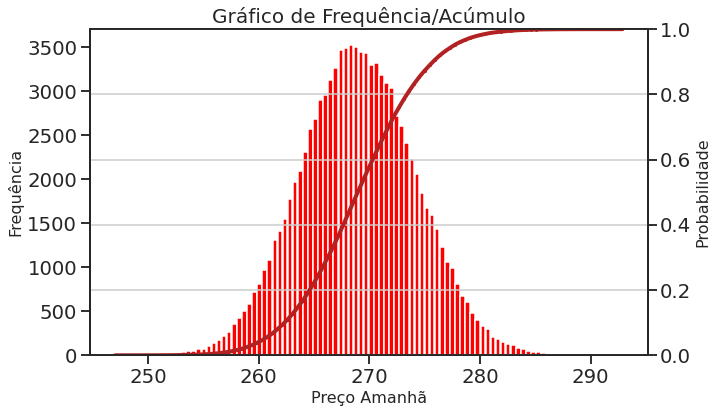

In [593]:
class Histplot:
  def __init__(self, x_data, num_bins, linetype="ro-", title=None, xlabel=None, ylabels=None, fsize=(20, 20), df_line=1):
    """
    :param x_data: data x list
    :param num_bins: the number of x groups
    :param linetype: The style of the cumulative frequency curve, the default is red solid point
    :param legends: legend name, default is “linear fitting result”, “actual measured value”
    :param xlabel: the name of the x axis title, default is “data x”
    :param ylabels: double y axis title name, the default is “count”, “cumulative frequency”
    :param df_line: Whether to display the cumulative frequency curve
    """
    if title is None:
      title = "Gráfico de Frequência/Acúmulo"
    if xlabel is None:
      xlabel = "Preço Amanhã"
    if ylabels is None:
      ylabels = ["Frequência", "Probabilidade"]
    self.x_data = x_data
    self.num_bins = num_bins
    self.linetype = linetype
    self.fsize = fsize
    self.title = title
    self.xlabel = xlabel
    self.ylabels = ylabels
    self.df_line = df_line
  def change_title(self, new_title):
    self.title = new_title
  def change_ylabel(self, new_labels):
    self.ylabels = new_labels
  def change_xlabel(self, new_label):
    self.xlabel = new_label
  def change_linetype(self, new_linetype):
    self.linetype = new_linetype
  def draw_plot(self):
    fs = self.fsize
    sns.set_style("ticks")
    sns.set_context("talk", font_scale=fs[1]*0.2)
    fig, ax = plt.subplots(figsize=fs)
    n, bins, patches = ax.hist(self.x_data, self.num_bins, color = "red", rwidth=0.9, label=self.title[0])
    ax.set_title(self.title, fontsize=20)
    ax.set_xlabel(self.xlabel, fontsize=16)
    ax.set_ylabel(self.ylabels[0], fontsize=16)
    if self.df_line:
      leiji_n = [sum(n[:i]) / M for i in range(len(n) + 1)]
      ax2 = ax.twinx()
      ax2.plot(bins, leiji_n, self.linetype, ms=fs[0]*0.2, color="firebrick", linewidth=4, label=self.title[0])
      ax2.set_ylim(0, 1)
      ax2.set_ylabel(self.ylabels[1], fontsize=16)
    plt.grid()
    plt.show()
if __name__ == "__main__":
  bins = 100
  plot1 = Histplot(df['ST'], num_bins=bins, fsize=(10, 6))
  plot1.draw_plot()

In [594]:
prediction = np.mean(df['ST'])
print("O preço previsto para o ativo amanhã é de:", "${:,}".format(round(prediction,2)))


O preço previsto para o ativo amanhã é de: $269.01


## Fontes:
https://medium.com/analytics-vidhya/how-to-simulate-the-stock-and-cryptocurrency-price-data-using-monte-carlo-simulation-275b9f18f556


https://github.com/ViniSpeck/ML/blob/main/aula%202%20-%20kmeans/main.ipynb


https://medium.com/@polanitzer/predict-the-bitcoin-prices-using-path-independent-monte-carlo-simulation-and-pythons-numpy-library-b7f19e2c3c57